In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import random
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
style_file = "./data/style/ghibli_square_1.png"
content_file = "./data/content/real_square_1_2.jpg"

#feeding in images of 224 x 224 px
imsize = 224

#running on cpu for now
#***TODO: Explore using online environments like Google Colab***
device = torch.device("cpu")

#resize images and convert to tensor
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

def image_loader(image_file):
    image = Image.open(image_file)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader(style_file)
content_img = image_loader(content_file)

assert style_img.size() == content_img.size()



torch.Size([1, 3, 224, 224])
tensor([[[[0.0157, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
          [0.0157, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
          [0.0157, 0.0157, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.3961, 0.3686, 0.3569,  ..., 0.5804, 0.4706, 0.4549],
          [0.4039, 0.4039, 0.3922,  ..., 0.4745, 0.5176, 0.6745],
          [0.3922, 0.3882, 0.3843,  ..., 0.5529, 0.5725, 0.7725]],

         [[0.5725, 0.5725, 0.5725,  ..., 0.5765, 0.5765, 0.5765],
          [0.5725, 0.5725, 0.5725,  ..., 0.5765, 0.5765, 0.5765],
          [0.5725, 0.5725, 0.5725,  ..., 0.5765, 0.5765, 0.5765],
          ...,
          [0.7647, 0.7451, 0.7373,  ..., 0.8039, 0.6588, 0.4431],
          [0.7804, 0.7804, 0.7686,  ..., 0.6784, 0.6000, 0.5059],
          [0.7647, 0.7490, 0.7373,  ..., 0.4784, 0.5216, 0.5608]],

         [[0.7333, 0.7373, 0.7412,  ..., 0.7529, 0.7529, 0.7529],
          [0.7333, 0.7373, 0.7412,  ..., 0.7529, 0.7529, 0.7529],
          [0.

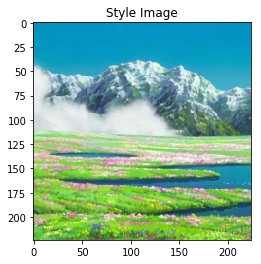

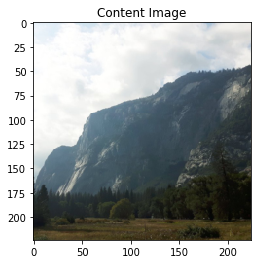

In [21]:
display = transforms.ToPILImage()

plt.ion()

#takes our tensors and converts them to viewable images in pyplot
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = display(image)
    if title is not None:
        plt.title(title)
    plt.imshow(image)


plt.figure()
imshow(style_img, title="Style Image")
print(style_img.shape)
print(style_img)

plt.figure()
imshow(content_img, title="Content Image")

In [4]:
def gram_matrix(input):
    #gram matrix (feature maps multiplied by its transpose) needed for calculating style loss
    #normalized because large N => large gram matrix entries
    #which means the initial layers before pooling will matter more than the deeper layers
    
    '''
        a: batch size
        b: number of feature maps
        (c,d): dimensions of a feature map (i.e. N = cd)
    '''
    a, b, c, d = input.size()
    features = input.view(a*b, c*d) #need to resize feature map into a K*N matrix
    
    G = torch.mm(features, features.t())
    
    #normalize values by dividing number of elements
    return G.div(a*b*c*d)

In [5]:
class ContentLoss(nn.Module):
    '''
        Content Loss defined as a 'distance' between intermediate outputs and content image
        Mean squared error of two feature maps
        ***TODO: Explore other loss functions? Not really sure what it would look like***
        
    '''
    def __init__(self, target):
            super(ContentLoss, self).__init__()
            self.target = target.detach()
            
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
        
class StyleLoss(nn.Module):
    '''
        Style Loss similarly uses mean squared error between gram matrices of style and intermediate inputs
    '''
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [6]:
#Using pretrained 19-layer VGG as proposed in the paper
cnn = models.vgg19(pretrained = True).features.to(device).eval()

#vgg is trained on channels normalized by mean (0.485, 0.456, 0,406) and std (0.229, 0.224, 0.225)
#***NORMALIZE IMAGES BEFORE SENDING THEM THROUGH
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.485, 0.456, 0.406])

class Normalization(nn.Module):
    def __init__ (self, mean, std):
        super(Normalization, self).__init__()
        '''
            need input image as [C, 1, 1]
            image Tensor has shape [B, C, H, W]
            B: Batch size
            C: Number of channels
            H: Height
            W: Width
        '''
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    
    def forward(self, image):
        return (image - self.mean) / self.std

In [7]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img, content_layers=content_layers_default, style_layers = style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    content_losses=[]
    style_losses=[]
    
    model = nn.Sequential(normalization)
    
    i=0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i+= 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'batchnorm_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
        model.add_module(name, layer)
        
        if name in content_layers:
            #adding content loss
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            #adding style loss
            target_feature = model(style_img)
            target_feature.detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            
    for i in range(len(model)-1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break
    model = model[:(i+1)]
        
    return model, style_losses, content_losses

In [19]:
test_model, style_losses, content_losses = get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std, style_img, content_img)
print(test_model)
test_model.pool_2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
test_model.pool_4 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)

for name, module in test_model.named_children():
    print(name)
    print(" and ")
    print(module)

/Users/rosiezhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/rosiezhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
0
 and 
Normalization()
conv_1
 and 
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
style_loss_1
 and 
StyleLoss()
re

<class 'PIL.Image.Image'>


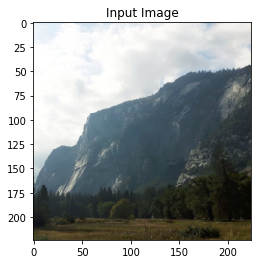

<Figure size 432x288 with 0 Axes>

In [8]:
#input image is our content image
'''
    ***TODO: Explore generating a white noise image..?***
    Paper mentions using gradient descent on white noise image for style reconstruction
'''
input_img_1 = content_img.clone()

plt.figure()
imshow(input_img_1, title='Input Image')

#alternatively start image with random white noise
def get_random_noise_image(width, height):
    im = Image.new("RGBA", (width, height), 255)
    random_grid = map(lambda x: (
            int(random.random() * 256),
            int(random.random() * 256),
            int(random.random() * 256)
        ), [0] * width * height)
    im.putdata(list(random_grid))
    print(type(im))
    return im

input_img_2 = get_random_noise_image(imsize, imsize)
plt.figure()
input_img_2.show()

In [9]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [10]:
#number of steps and weight to apply to differences for style and content loss
steps=1000
s_weight = 1000000
c_weight = 1

def style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=steps, style_weight=s_weight, content_weight = c_weight):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    
    #arrays to graph style loss and content loss vs steps
    s_loss_points = []
    c_loss_points = []
    steps=[]
    
    #tracking number of steps
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            input_img.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            
            for s in style_losses:
                style_score += s.loss
            for c in content_losses:
                content_score += c.loss
            
            style_score *= style_weight
            content_score *= content_weight
            
            #loss function is our weighted sum between style and content, defined in paper
            loss = style_score + content_score
            #minimize this loss
            loss.backward()
            
            run[0]+= 1
            
            #printing to track progress, add points to plot
            if run[0] % 25 == 0:
                print("run {}:".format(run))
                print("Style Loss: {:4f}, Content Loss: {:4f}".format(style_score.item(), content_score.item()))
                s_loss_points.append(style_score.item())
                c_loss_points.append(content_score.item())
                steps.append(run[0])
        
            return style_score + content_score
        
        optimizer.step(closure)
    #ensures our normalized image pixel values are still between 0 and 1
    input_img.data.clamp_(0,1)
    
    #plot graph
    plt.figure()
    plt.plot(steps, s_loss_points, c='r')
    plt.plot(steps, c_loss_points, c='b')
    plt.title("Style and Content Loss")
    plt.xlabel("Number of Steps")
    plt.ylabel("Loss")
    plt.savefig("./data/graph_1_steps_1000.png", format="png")
    
    return input_img
        

/Users/rosiezhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/rosiezhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


run [25]:
Style Loss: 2.037367, Content Loss: 5.836510
run [50]:
Style Loss: 1.297311, Content Loss: 6.042453
run [75]:
Style Loss: 1.002260, Content Loss: 6.082730
run [100]:
Style Loss: 0.835086, Content Loss: 6.086339
run [125]:
Style Loss: 0.714781, Content Loss: 6.090993
run [150]:
Style Loss: 0.638604, Content Loss: 6.077000
run [175]:
Style Loss: 0.579200, Content Loss: 6.076365
run [200]:
Style Loss: 0.551676, Content Loss: 6.074265
run [225]:
Style Loss: 0.516832, Content Loss: 6.062845
run [250]:
Style Loss: 0.508164, Content Loss: 6.052951
run [275]:
Style Loss: 0.479902, Content Loss: 6.054832
run [300]:
Style Loss: 0.477668, Content Loss: 6.047392
run [325]:
Style Loss: 0.464669, Content Loss: 6.042356
run [350]:
Style Loss: 0.490701, Content Loss: 6.064712
run [375]:
Style Loss: 0.454559, Content Loss: 6.040140
run [400]:
Style Loss: 0.450614, Content Loss: 6.037110
run [425]:
Style Loss: 0.801916, Content Loss: 6.128666
run [450]:
Style Loss: 0.448131, Content Loss: 6.06

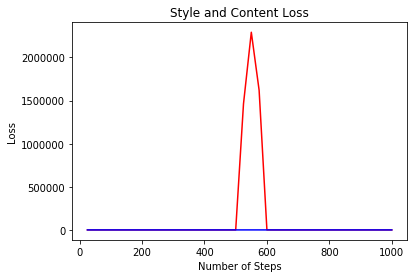

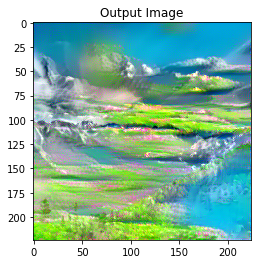

In [123]:
#running this bad boy
output = style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

#displays output image
plt.figure()
imshow(output, title='Output Image')

plt.show()

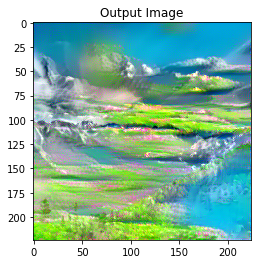

In [124]:
#save output image
plt.figure()
imshow(output, title='Output Image')
plt.savefig("./data/output_1_1000.png", format="png")